<a href="https://colab.research.google.com/github/tjens150/ML_practice/blob/main/JAX_practice.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# JAX Practice
Here I code an MLP from scratch using JAX. I also use FLAX to construct a CNN and compare.

This code is messy and I prepare to clean it up in the future...

Preparing to load stellar spectra from SDSS' Apogee telescope. Data loading is thanks to David W. Hogg at NYU

In [ ]:
import numpy as np
from astropy.io import fits
import pylab as plt # only needed for verification

In [ ]:
# construct url to the file of labels and read it
base_url = "https://data.sdss.org/sas/dr17/apogee/spectro/aspcap/dr17/synspec_rev1/"
fn = "allStarLite-dr17-synspec_rev1.fits"
allstar = fits.open(base_url + fn)
for a in allstar:
    print(a)

In [ ]:
# the labels are in an enormous table in element [1] of this FITS file
labels = allstar[1].data
plt.scatter(labels['TEFF'], labels['LOGG'], s=1)
plt.xlim(6000, 3500)
plt.ylim(5, 0)

In [ ]:
# make a reasonable red-giant-branch sample
RGB = True
RGB = np.logical_and(RGB, labels['TEFF'] > 3500.)
RGB = np.logical_and(RGB, labels['TEFF'] < 5400.)
RGB = np.logical_and(RGB, labels['LOGG'] < 3.0)
RGB = np.logical_and(RGB, labels['LOGG'] > 0.0)
RGB = np.logical_and(RGB, labels['H'] < 10.5)
print(np.sum(RGB))

In [ ]:
# make a plot that an astronomer likes to see
RGB_labels = labels[RGB]
plt.scatter(RGB_labels['TEFF'], RGB_labels['LOGG'], c=RGB_labels['FE_H'], s=1)
plt.xlim(5400, 3500)
plt.xlabel("effective temperature")
plt.ylim(3., 0.)
plt.ylabel("log10 surface gravity")
plt.colorbar(label="metallicity")

In [ ]:
# make train, validation, and test data sets
rng = np.random.default_rng(17)
N_RGB = len(RGB_labels)
N_train, N_valid, N_test = 1024, 256, 512
I = rng.permutation(N_RGB)
I_train = I[0:N_train]
I_valid = I[N_train:N_train+N_valid]
I_test = I[N_train+N_valid:N_train+N_valid+N_test]
train_labels = RGB_labels[I_train]
valid_labels = RGB_labels[I_valid]
test_labels = RGB_labels[I_test]
print(len(train_labels), len(valid_labels), len(test_labels))

In [ ]:
# Plot the labels of the three data sets
# make a plot that an astronomer likes to see
for l, t in [(train_labels, "Training Set"),
             (valid_labels, "Validation Set"),
             (test_labels, "Test Set")]:
    plt.figure()
    plt.title(t)
    plt.scatter(l['TEFF'], l['LOGG'], c=l['FE_H'], s=1)
    plt.xlim(5400, 3500)
    plt.xlabel("effective temperature")
    plt.ylim(3., 0.)
    plt.ylabel("log10 surface gravity")
    plt.colorbar(label="metallicity")

In [ ]:
# now time to read the spectral data - the features - this HURTS
def get_features(labels):
    features = None
    for l in labels:
        url = base_url + l['TELESCOPE'] + "/" + l['FIELD'] + "/aspcapStar-dr17-" + l['APOGEE_ID'] + ".fits"
        x = fits.open(url)[1].data
        if features is None:
            features = x[None, :]
        else:
            features = np.concatenate((features, x[None, :]), axis=0)
    return features

In [ ]:
# This will take a while, the first time you run it. Don't be alarmed.
train_features = get_features(train_labels)
valid_features = get_features(valid_labels)
test_features = get_features(test_labels)
print(train_features.shape, valid_features.shape, test_features.shape)

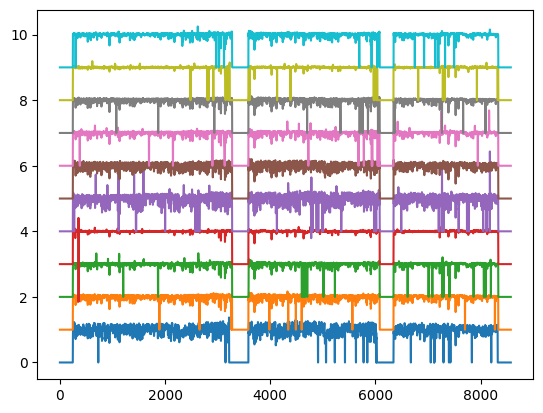

In [ ]:
for i in range(10):
    plt.plot(train_features[i] + i)

# MLP from scratch using JAX

This was inspired by Robert Lange's blog post: https://roberttlange.com/posts/2020/03/blog-post-10/

In [ ]:
import jax.numpy as jnp
from jax import grad, jit, vmap, value_and_grad
from jax import random, tree_map
from sklearn.preprocessing import StandardScaler
import time
import pdb
key = random.PRNGKey(42)

<ipython-input-12-166860729816>:3: DeprecationWarning: jax.tree_map is deprecated: use jax.tree.map (jax v0.4.25 or newer) or jax.tree_util.tree_map (any JAX version).
  from jax import random, tree_map


In [ ]:
def ReLU(x):
  return jnp.maximum(0,x)

def relu_layer(params, x):
    return ReLU(jnp.dot(params[0], x) + params[1])

def initialize_mlp(sizes, key):
    """ Initialize the weights of all layers of a linear layer network """
    keys = random.split(key, len(sizes))
    # Initialize a single layer with Gaussian weights -  helper function
    def initialize_layer(m, n, key, scale=1e-2):
        w_key, b_key = random.split(key)
        return scale * random.normal(w_key, (n, m)), scale * random.normal(b_key, (n,))
        #return jnp.column_stack((scale * random.normal(b_key, (n,)),scale * random.normal(w_key, (n, m))))
    return [initialize_layer(m, n, k) for m, n, k in zip(sizes[:-1], sizes[1:], keys)]#,scale=jnp.sqrt(2/m)

def forward_pass(params, in_array):
    """ Compute the forward pass for each example individually """
    activations = in_array

    # Loop over the ReLU hidden layers

    for w, b in params[:-1]:
        activations = relu_layer([w, b], activations)
    #for w in params[:-1]:
    #    activations = relu_layer([w[:,1:], w[:,0]], activations)

    # Perform final trafo to logits
    final_w, final_b = params[-1]
    #final_w, final_b = params[-1][:,1:], params[-1][:,0]
    logits = jnp.dot(final_w, activations) + final_b
    return logits

# Make a batched version of the `predict` function
batch_forward = vmap(forward_pass, in_axes=(None, 0), out_axes=0)

def loss(params, in_arrays, targets):
  pred = batch_forward(params, in_arrays).ravel()
  return (jnp.sum((pred-targets)**2))/in_arrays.shape[0]

@jit
def update(params, x, y, eta=0.01):
  value, grads = value_and_grad(loss)(params, x, y)
  return tree_map(lambda u, g: u-eta*g, params, grads), jnp.sqrt(value)
  #return [params[p]-eta*grads[p] for p in range(len(params))], jnp.sqrt(value)




In [ ]:
def train_MLP(x_train,y_train,x_val,y_val,num_epochs,params, key,eta=0.01,batch_size=32):
  rmse_train, rmse_val, rmse_batch = [], [], []
  def thiseta(t, eta):
    return eta
  if np.asarray(eta).size == 2:
    def thiseta(t,t0,t1):
      return t0 / (t + t1)

  this_rmse=jnp.sqrt(loss(params,x_train,y_train))
  this_rmse_val=jnp.sqrt(loss(params,x_val,y_val))
  rmse_train.append(this_rmse)
  rmse_val.append(this_rmse_val)

  for epoch in range(num_epochs):
    start_time = time.time()
    num_b=jnp.ceil(x_train.shape[0]/batch_size).astype(int)
    key, batch_key = random.split(key)
    rand_ind=random.permutation(batch_key, jnp.arange(x_train.shape[0]))
    for bb in range(num_b):
      this_ind=rand_ind[batch_size*bb:batch_size*(bb+1)]
      x=x_train[this_ind]
      y=y_train[this_ind]
      params, t_loss = update(params, x, y, eta=thiseta(epoch*num_b+bb,*eta))
      rmse_batch.append(t_loss)
    this_rmse=jnp.sqrt(loss(params,x_train,y_train))
    this_rmse_val=jnp.sqrt(loss(params,x_val,y_val))
    rmse_train.append(this_rmse)
    rmse_val.append(this_rmse_val)
    print('epoch %s time: %s | train rms: %s | val rms: %s' % (epoch, time.time()-start_time,this_rmse, this_rmse_val))
  return params, rmse_train, rmse_val, rmse_batch





In [ ]:
from sklearn.preprocessing import add_dummy_feature
from sklearn.preprocessing import StandardScaler
std_scaler = StandardScaler()
x_train=std_scaler.fit_transform(np.asarray(train_features))
#x_train=add_dummy_feature(std_scaler.fit_transform(np.asarray(train_features)))
y_train=train_labels['LOGG'].astype('f')
x_val=std_scaler.transform(np.asarray(valid_features))
#x_val=add_dummy_feature(std_scaler.transform(np.asarray(valid_features)))
y_val=valid_labels['LOGG'].astype('f')
layer_sizes = [x_train.shape[1], 200, 200, 1]
params = initialize_mlp(layer_sizes, key)
num_epochs=20
key,__=random.split(key)
t0, t1 = num_epochs/10, num_epochs # learning schedule hyperparameters
params, rmse_train, rmse_val, rmse_batch=train_MLP(x_train,y_train,x_val,y_val,num_epochs,params, key,eta=(t0,t1),batch_size=32)


epoch 0 time: 0.9710595607757568 | train rms: 0.27296793 | val rms: 0.2963297
epoch 1 time: 0.398181676864624 | train rms: 0.20179836 | val rms: 0.27610013
epoch 2 time: 0.5418977737426758 | train rms: 0.1603938 | val rms: 0.26679435
epoch 3 time: 0.6980924606323242 | train rms: 0.14533165 | val rms: 0.26213622
epoch 4 time: 0.6686458587646484 | train rms: 0.13897027 | val rms: 0.2554326
epoch 5 time: 0.7252275943756104 | train rms: 0.13102649 | val rms: 0.2581125
epoch 6 time: 0.6815981864929199 | train rms: 0.12614624 | val rms: 0.25335696
epoch 7 time: 0.5224027633666992 | train rms: 0.12223106 | val rms: 0.25311142
epoch 8 time: 0.4690415859222412 | train rms: 0.11954075 | val rms: 0.25198868
epoch 9 time: 0.38695240020751953 | train rms: 0.11689049 | val rms: 0.25215387
epoch 10 time: 0.38779306411743164 | train rms: 0.11484973 | val rms: 0.25300977
epoch 11 time: 0.3874218463897705 | train rms: 0.11304476 | val rms: 0.2524567
epoch 12 time: 0.38521456718444824 | train rms: 0.1113

In [ ]:
for p in params:
  print(p[0].shape, p[1].shape)

(200, 8575) (200,)
(200, 200) (200,)
(1, 200) (1,)


0.2452589


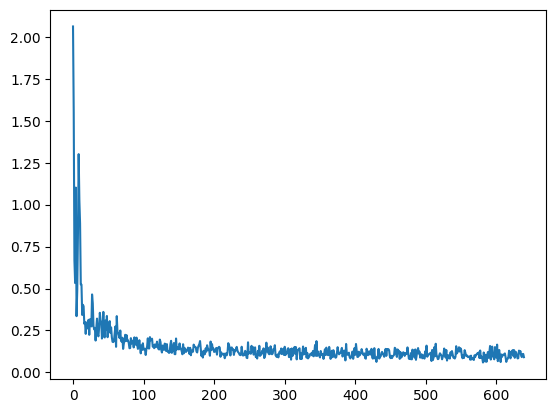

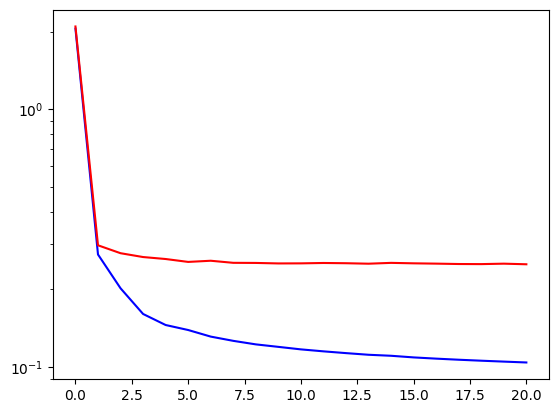

In [ ]:
x_test=std_scaler.transform(np.asarray(test_features))
y_test=test_labels['LOGG'].astype('f')
print(jnp.sqrt(loss(params,x_test,y_test)))
fig,ax=plt.subplots(1,1)
ax.plot(rmse_batch)
fig,ax=plt.subplots(1,1)
ax.plot(np.arange(num_epochs+1), rmse_train,color='blue')
ax.plot(np.arange(num_epochs+1), rmse_val,color='red')
ax.set_yscale('log')



# Construct a CNN using FLAX

In [ ]:
import flax.linen as nn
# class MLP(nn.Module):                    # create a Flax Module dataclass
#   out_dims: int

#   @nn.compact
#   def __call__(self, x):
#     x = x.reshape((x.shape[0], -1))
#     x = nn.Dense(128)(x)                 # create inline Flax Module submodules
#     x = nn.relu(x)
#     x = nn.Dense(self.out_dims)(x)       # shape inference
#     return x

# model = MLP(out_dims=10)                 # instantiate the MLP model

# x = jnp.empty((1024))            # generate random data
# variables = model.init(random.key(42), x)# initialize the weights
# y = model.apply(variables, x)

In [ ]:
class CNN(nn.Module):
  @nn.compact
  def __call__(self, x):
    x = nn.Conv(features=32, kernel_size=(3,),padding='valid')(x)
    x = nn.relu(x)
    x = nn.avg_pool(x, window_shape=(2,), strides=(2,))
    x = nn.Conv(features=64, kernel_size=(3,))(x)
    x = nn.relu(x)
    x = nn.avg_pool(x, window_shape=(2,), strides=(2,))
    x = x.reshape((x.shape[0], -1))  # flatten
    x = nn.Dense(features=256)(x)
    x = nn.relu(x)
    x = nn.Dense(features=1)(x)
    #x = nn.log_softmax(x)
    return x

model = CNN()
batch_size=32
#batch =  jnp.ones(shape=(x_train[:batch_size,:].shape)).reshape(batch_size,x_train.shape[1],1) # (N, H, W, C) format
batch =  x_train[:batch_size,:][:,:,None] # (N, H, W, C) format
key,__=random.split(key)
variables = model.init(key, batch)
output = model.apply(variables, batch)

In [ ]:
8575/4.*64

137200.0

In [ ]:
batch_forward = vmap(model.apply, in_axes=(None, 0), out_axes=0)

In [ ]:
tree_map(lambda x: x.shape, variables)
#variables['params']['Conv_0']['kernel'].shape
# for layer_params in variables["params"].items():
#     print("Layer Name : {}".format(layer_params[0]))
#     weights, biases = layer_params[1]["kernel"], layer_params[1]["bias"]
#     print("\tLayer Weights : {}, Biases : {}".format(weights.shape, biases.shape))

{'params': {'Conv_0': {'bias': (32,), 'kernel': (3, 1, 32)},
  'Conv_1': {'bias': (64,), 'kernel': (3, 32, 64)},
  'Dense_0': {'bias': (256,), 'kernel': (137152, 256)},
  'Dense_1': {'bias': (1,), 'kernel': (256, 1)}}}

In [ ]:
def loss(params, in_arrays, targets):
  #pred = batch_forward(params, in_arrays).ravel()
  pred = model.apply(params, in_arrays).ravel()
  #pdb.set_trace()
  return (jnp.sum((pred-targets)**2))/in_arrays.shape[0]

@jit
def update(params, x, y, eta=0.01):
  value, grads = value_and_grad(loss)(params, x, y)
  return tree_map(lambda u, g: u-eta*g, params, grads), jnp.sqrt(value)
  #return [params[p]-eta*grads[p] for p in range(len(params))], jnp.sqrt(value)


def train_CNN(x_train,y_train,x_val,y_val,num_epochs,params, key,eta=0.01,batch_size=32):
  rmse_train, rmse_val, rmse_batch = [], [], []
  def thiseta(t, eta):
    return eta
  if np.asarray(eta).size == 2:
    def thiseta(t,t0,t1):
      return t0 / (t + t1)

  this_rmse=jnp.sqrt(loss(params,x_train[:,:,None],y_train))
  this_rmse_val=jnp.sqrt(loss(params,x_val[:,:,None],y_val))
  rmse_train.append(this_rmse)
  rmse_val.append(this_rmse_val)

  for epoch in range(num_epochs):
    start_time = time.time()
    num_b=jnp.ceil(x_train.shape[0]/batch_size).astype(int)
    key, batch_key = random.split(key)
    rand_ind=random.permutation(batch_key, jnp.arange(x_train.shape[0]))
    for bb in range(num_b):
      this_ind=rand_ind[batch_size*bb:batch_size*(bb+1)]
      x=x_train[this_ind][:,:,None]
      y=y_train[this_ind]
      params, t_loss = update(params, x, y, eta=thiseta(epoch*num_b+bb,*eta))
      rmse_batch.append(t_loss)
    this_rmse=jnp.sqrt(loss(params,x_train[:,:,None],y_train))
    this_rmse_val=jnp.sqrt(loss(params,x_val[:,:,None],y_val))
    rmse_train.append(this_rmse)
    rmse_val.append(this_rmse_val)
    print('epoch %s time: %s | train rms: %s | val rms: %s' % (epoch, time.time()-start_time,this_rmse, this_rmse_val))
  return params, rmse_train, rmse_val, rmse_batch





In [ ]:
#batch =  x_train[0,:].reshape(1,-1) # (N, H, W, C) format
batch_size=32
batch =  x_train[:batch_size,:][:,:,None] # (N, H, W, C) format
key,__=random.split(key)
params = model.init(key, batch)
num_epochs=20
key,__=random.split(key)
t0, t1 = num_epochs/10, num_epochs # learning schedule hyperparameters
params, rmse_train, rmse_val, rmse_batch=train_CNN(x_train,y_train,x_val,y_val,num_epochs,params, key,eta=(1e-2,),batch_size=batch_size)

epoch 0 time: 53.3571834564209 | train rms: 1.6900767 | val rms: 1.7266474
epoch 1 time: 48.07416653633118 | train rms: 0.26069096 | val rms: 0.2694026
epoch 2 time: 48.860034704208374 | train rms: 0.2052573 | val rms: 0.22314073
epoch 3 time: 46.707778453826904 | train rms: 0.19670723 | val rms: 0.21494383
epoch 4 time: 47.5437445640564 | train rms: 0.17253469 | val rms: 0.1960354
epoch 5 time: 47.03097748756409 | train rms: 0.19067922 | val rms: 0.21463338
epoch 6 time: 46.293936252593994 | train rms: 0.18215425 | val rms: 0.2081093
epoch 7 time: 46.549428939819336 | train rms: 0.14232114 | val rms: 0.17418024
epoch 8 time: 47.23377704620361 | train rms: 0.14344308 | val rms: 0.17828497
epoch 9 time: 44.927961349487305 | train rms: 0.13693362 | val rms: 0.17620121
epoch 10 time: 46.07750129699707 | train rms: 0.13192816 | val rms: 0.17271864
epoch 11 time: 46.68056654930115 | train rms: 0.14358954 | val rms: 0.18831624
epoch 12 time: 46.75294375419617 | train rms: 0.12849808 | val rm

0.15564366


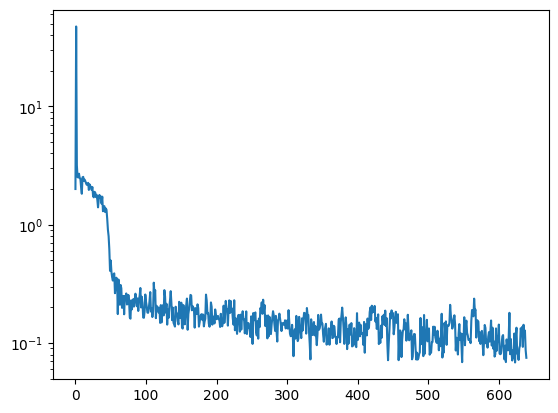

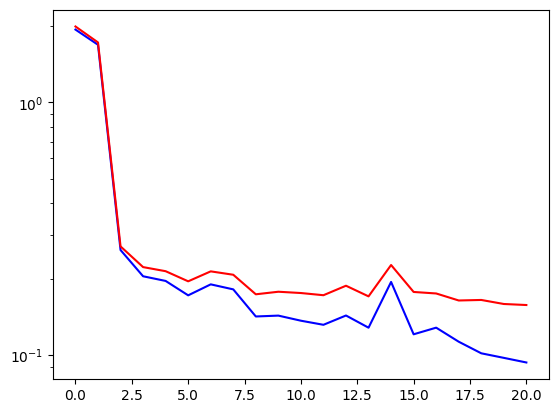

In [ ]:
x_test=std_scaler.transform(np.asarray(test_features))
y_test=test_labels['LOGG'].astype('f')
print(jnp.sqrt(loss(params,x_test[:,:,None],y_test)))
fig,ax=plt.subplots(1,1)
ax.plot(rmse_batch)
ax.set_yscale('log')
fig,ax=plt.subplots(1,1)
ax.plot(np.arange(num_epochs+1), rmse_train,color='blue')
ax.plot(np.arange(num_epochs+1), rmse_val,color='red')
ax.set_yscale('log')


In [ ]:
params, rmse_train, rmse_val, rmse_batch=train_CNN(x_train,y_train,x_val,y_val,num_epochs,params, key,eta=(t0,t1),batch_size=batch_size)

epoch 0 time: 48.02627873420715 | train rms: 0.7230382 | val rms: 0.7060416
epoch 1 time: 58.23166275024414 | train rms: 0.70474 | val rms: 0.6757502
epoch 2 time: 48.292577505111694 | train rms: 0.70456123 | val rms: 0.6744145
epoch 3 time: 49.14044213294983 | train rms: 0.7045693 | val rms: 0.6745976
epoch 4 time: 46.50213623046875 | train rms: 0.7045609 | val rms: 0.6741902
epoch 5 time: 48.89267706871033 | train rms: 0.7045609 | val rms: 0.67439914
epoch 6 time: 46.89367914199829 | train rms: 0.7045602 | val rms: 0.67436683
epoch 7 time: 46.18091082572937 | train rms: 0.7045599 | val rms: 0.67424303
epoch 8 time: 45.46139645576477 | train rms: 0.70456076 | val rms: 0.6741946
epoch 9 time: 49.325570821762085 | train rms: 0.70455986 | val rms: 0.6742524
epoch 10 time: 47.630940437316895 | train rms: 0.7045598 | val rms: 0.6743333
epoch 11 time: 47.45326852798462 | train rms: 0.7045596 | val rms: 0.67428756
epoch 12 time: 49.28180909156799 | train rms: 0.7045597 | val rms: 0.6743176
e

In [ ]:
layer_sizes = [x_train.shape[1], 50, 50, 50, 50, 1]
params = initialize_mlp(layer_sizes, key)
num_epochs=50
t0, t1 = num_epochs/10, num_epochs # learning schedule hyperparameters
key,__=random.split(key)
params, rmse_train, rmse_val, rmse_batch=train_MLP(x_train,y_train,x_val,y_val,num_epochs,params, key,eta=(t0,t1),batch_size=32)

0.67966306


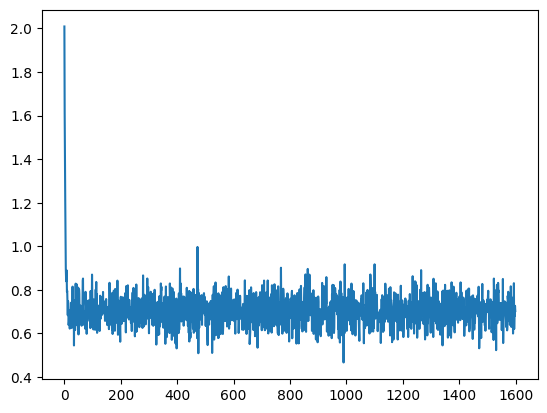

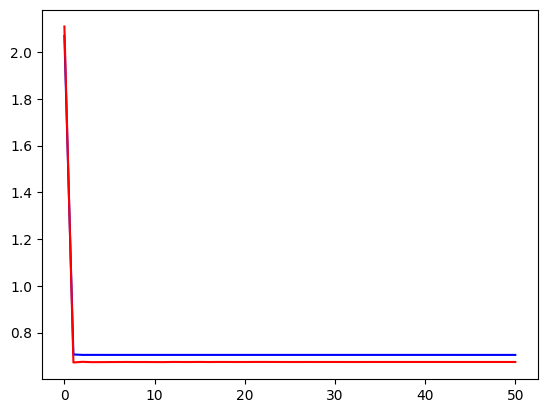

In [ ]:
print(jnp.sqrt(loss(params,x_test,y_test)))
fig,ax=plt.subplots(1,1)
ax.plot(rmse_batch)
fig,ax=plt.subplots(1,1)
ax.plot(np.arange(num_epochs+1), rmse_train,color='blue')
ax.plot(np.arange(num_epochs+1), rmse_val,color='red')


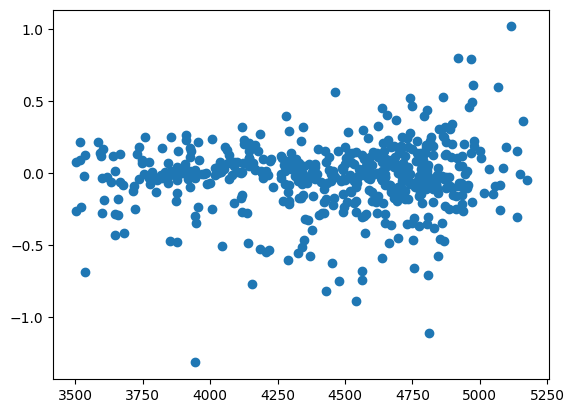

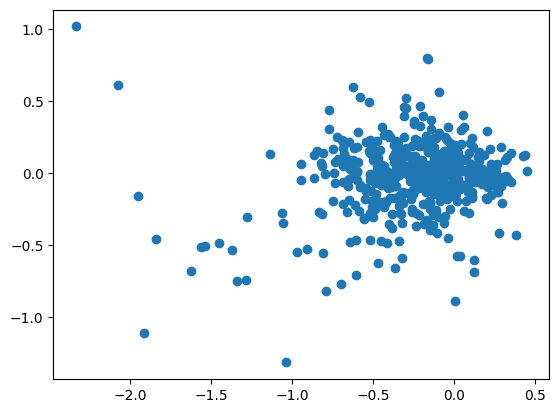

In [ ]:
pred = batch_forward(params, x_test).ravel()
fig,ax=plt.subplots(1,1)
ax.plot(test_labels['TEFF'], y_test-pred, linestyle='',marker='o')
fig,ax=plt.subplots(1,1)
ax.plot(test_labels['FE_H'], y_test-pred, linestyle='',marker='o')

In [ ]:
from jax.experimental import stax
from jax.experimental.stax import (BatchNorm, Conv, Dense, Flatten,
                                   Relu, LogSoftmax)

ImportError: cannot import name 'stax' from 'jax.experimental' (/usr/local/lib/python3.10/dist-packages/jax/experimental/__init__.py)